In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.tools import tool
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults 

@tool
def get_web_search(query: str, search_period: str='w') -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색어
        search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)

    Returns:
        str: 검색 결과
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        region="kr-kr",
        time=search_period
    )

    print('\n----- WEB SEARCH -----')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[get_web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [7]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

In [8]:
supervisor_agent = create_react_agent(
    model="google_genai:gemini-2.5-flash",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [9]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

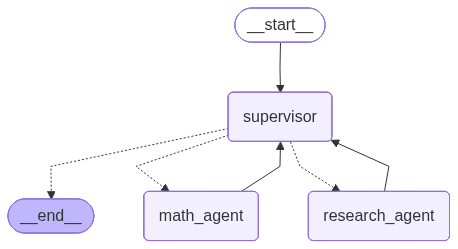

In [10]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [13]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "현재 박스오피스 1위 영화가 무엇이며 관람객 수를 보고서로 작성해줘?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent



----- WEB SEARCH -----
현재 박스오피스 1위 영화 관람객 수
w
1. snippet: 현재 (hyeon-jae) Definition of 현재 Both 현재 and 이제 are the same in meaning, but different in nuisance. 이제 is like the right moment of the present time or right now. e.g, 이제 가 봐야겠다. I got to …, title: What is the meaning of "현재"? - Question about Korean, link: https://hinative.com/questions/16923851
2. snippet: 현재 (hyeon-jae)현재的意思Both 현재 and 이제 are the same in meaning, but different in nuisance. 이제 is like the right moment of the present time or right now. e.g, 이제 가 봐야겠다. I got to go now (= I …, title: "현재"是什麼意思？ - 關於韓語（韓文）的問題 | HiNative, link: https://tw.hinative.com/questions/16923851
3. snippet: 【ネイティブが回答】「-냐는 (과거, 현재, 미래 시제)」を使った自然な例文を知りたい！12件の日常で使える回答が集まっています！Hinativeでは"韓国語"や外国語の勉強で気になったことを、ネイティブ …, title: 냐는 (과거, 현재, 미래 시제)】 を使った例文を教えて下さい 

In [14]:
final_message_history

[HumanMessage(content='현재 박스오피스 1위 영화가 무엇이며 관람객 수를 보고서로 작성해줘?', additional_kwargs={}, response_metadata={}, id='2be90931-b29c-4ce9-8c32-2692240ec2f0'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_agent', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='supervisor', id='run--d0367327-5921-448f-ba77-e6c9edcea1ae-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'fd15f72e-beff-43e9-8f75-eabe0c64ba64', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 68, 'total_tokens': 218, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 54}}),
 ToolMessage(content='Successfully transferred to research_agent', name='transfer_to_research_agent', id='1dc44eca-b05d-4511-873a-341448d3aa92', tool_call_id='fd15f72e-beff-43e9-8f75-eabe0c64ba64'),


In [15]:
print(final_message_history[-2].content)

## 박스오피스 1위 영화 및 관람객 수 보고서

**영화명:** 어쩔수가없다 (감독: 박찬욱)

**현재 박스오피스 순위:** 1위 (3일 연속)

**관람객 수:**
*   **누적 관객 수:** 591,407명
*   **최근 일일 관객 수 (9월 26일 기준):** 127,031명
